In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import pandas as pd
import tensorflow as tf
import keras
import seaborn as sns 
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report

2023-04-13 20:26:15.923601: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
df = pd.read_csv('Resources_Clean/Result_Protein_Peptide_Combine.csv')

In [25]:
df.head()

,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,On,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,...,62329,62437,62723,62732,62792,63875,63889,64669,64674,65043
0,0,10.0,6.0,15.0,0.0,0,8984260.0,53855.6,8579740.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,6,8.0,10.0,34.0,0.0,0,8279770.0,45251.9,8655890.0,49927.5,...,0,0,0,0,0,0,0,0,0,0
2,12,10.0,10.0,41.0,0.0,1,8382390.0,53000.9,8995640.0,45519.2,...,0,0,0,0,0,0,0,0,0,0
3,36,17.0,18.0,51.0,0.0,1,10671500.0,58108.4,9985420.0,52374.0,...,0,0,0,0,0,0,0,0,0,0
4,6,8.0,2.0,21.0,0.0,0,6177730.0,42682.6,3596660.0,25698.8,...,0,0,0,0,0,0,0,0,0,0


In [26]:
import re

In [27]:
df['sum_score'] = df[df.filter(regex = 'updrs').columns].sum(axis = 1)
df.drop(df.filter(regex = 'updrs').columns, axis = 1, inplace = True)

In [28]:
df['sum_score']

0       31.0
1       52.0
2       61.0
3       86.0
4       31.0
        ... 
1063    75.0
1064    24.0
1065    25.0
1066    12.0
1067    26.0
Name: sum_score, Length: 1068, dtype: float64

## Feature Selection

### Correlation 

In [5]:
corr_ = abs(df.corr()[['sum_score']])
corr_ = corr_.sort_values(by = 'sum_score', ascending = False)
corr_ = corr_[corr_.index != 'sum_score']

In [6]:
corr_.head()

,sum_score
On,0.265636
FIYGGC(UniMod_4)GGNR,0.240760
P43121,0.237267
TLKIENVSYQDKGNYR,0.234878
P17174,0.232606


In [7]:
corr_.describe()

,sum_score
count,1445.000000
mean,0.072024
std,0.052712
min,0.000066
25%,0.029188
50%,0.062829
75%,0.102504
max,0.265636


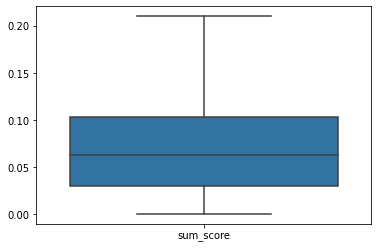

In [8]:
sns.boxplot(data = corr_, showfliers = False)
plt.show()

In [9]:
# Selection of correlated columns to Y. 
cut_off = [0.1, 0.06, 0.03]

corr_against_y = list()

for number in cut_off:
    col = corr_[corr_['sum_score'] > number]
    col = col.index.tolist()
    print(f'The length of features is {len(col)}')
    corr_against_y.append(col)

The length of features is 382
The length of features is 754
The length of features is 1080


### Co-Variance 

In [10]:
import numpy as np

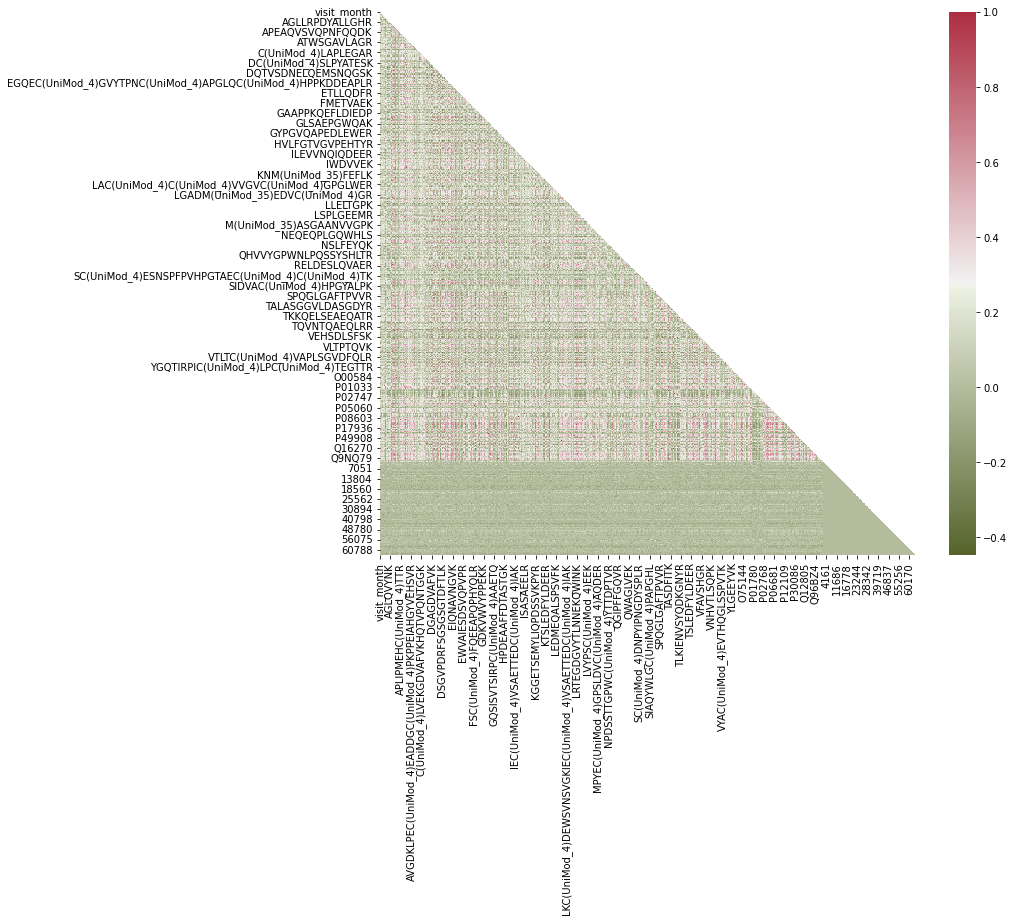

In [11]:
# HeatMap Creation 
cor = df.corr()
cor.drop('sum_score', axis = 1, inplace = True)

# Create a mask
mask = np.triu(np.ones_like(cor, dtype=bool))

# Create a custom divergin palette
cmap = sns.diverging_palette(100, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)

plt.figure(figsize=(12,10))

sns.heatmap(cor, mask=mask, cmap= cmap)

plt.show();

In [12]:
# Removal of Covariance Columns 
# Code snippet taken from krishnaik06 https://github.com/krishnaik06/Complete-Feature-Selection

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [13]:
corr_col = list()

for threshold in [0.6, 0.7, 0.8]:
    covariance = correlation(cor, threshold)
    columns = list(covariance)
    print(f'The number of covariant features is {len(columns)} with a threshold of {threshold}')
    corr_col.append(columns)

The number of covariant features is 1240 with a threshold of 0.6
The number of covariant features is 1181 with a threshold of 0.7
The number of covariant features is 1102 with a threshold of 0.8


### Generating Features  

In [14]:
# Removal of covariant features 
remove_corr = list()

for i in range(0, 3):
        
    # Appending corr_against_y 
    remove_corr.append(corr_against_y[i])   
    print(f'Number of features after low_correlation removal: {len(corr_against_y[i])}')
    
    # Appending co-variant 
    remove_corr.append(corr_col[i])
    print(f'Number of features after low_correlation removal: {len(corr_col[i])}')

Number of features after low_correlation removal: 382
Number of features after low_correlation removal: 1240
Number of features after low_correlation removal: 754
Number of features after low_correlation removal: 1181
Number of features after low_correlation removal: 1080
Number of features after low_correlation removal: 1102


In [15]:
dict_ = {}

for i in range(0, 6):
    dict_[i] = [remove_corr[i]]

In [16]:
df_col = pd.DataFrame(dict_).transpose()
df_col.columns = ['features']

In [17]:
df_col

,features
0,"[On, FIYGGC(UniMod_4)GGNR, P43121, TLKIENVSYQD..."
1,"[HLSLLTTLSNR, VRGGEGTGYFVDFSVR, Q14515, ALEQDL..."
2,"[On, FIYGGC(UniMod_4)GGNR, P43121, TLKIENVSYQD..."
3,"[HLSLLTTLSNR, VKDLATVYVDVLK, VRGGEGTGYFVDFSVR,..."
4,"[On, FIYGGC(UniMod_4)GGNR, P43121, TLKIENVSYQD..."
5,"[HLSLLTTLSNR, VKDLATVYVDVLK, VRGGEGTGYFVDFSVR,..."


In [18]:
df_col.to_csv('Resources_Clean/features.csv', index = False)